<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

In [3]:
df.shape

(3755, 11)

In [4]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [5]:
# Ваш код здесь
# Создаем словарь с допустимыми значениями для каждого признака
valid_values = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'],
    'employment_type': ['FT', 'PT', 'CT', 'FL'],
    'remote_ratio': [0, 50, 100],
    'company_size': ['S', 'M', 'L']
}

# Проверяем каждый признак
for column, valid in valid_values.items():
    actual_values = df[column].unique()
    invalid_values = set(actual_values) - set(valid)
    
    if len(invalid_values) > 0:
        print(f'{column} - недопустимые значения: {invalid_values}')
    else:
        print(f'{column} - OK')

experience_level - OK
employment_type - OK
remote_ratio - OK
company_size - OK


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

#### Пропуски

In [6]:
# Ваш код здесь
df.isnull().sum()


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

✅ Пропусков нет.

#### Дубликаты

In [7]:
print("Количество дубликатов:", df.duplicated().sum())

Количество дубликатов: 1171


Удалим полные дубликаты

In [8]:
df = df.drop_duplicates()
print(f"Размер датасета после удаления дубликатов: {df.shape}")

Размер датасета после удаления дубликатов: (2584, 11)


#### Типы данных

In [9]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

✅ Типы данных корректны.  
На следующих шагах, возможно, переведем тип `object` в `category`.

#### Базовая статистика для числовых столбцов

In [10]:
print("Статистика по числовым признакам:")
df.describe()


Статистика по числовым признакам:


,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [11]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


✅ Диапазоны значений корректны.  
Вызывает сомнение согласованность признаков `salary` и `salary_in_usd`. Проверим это.

#### Курсы валют

Введем новый признак `usd_rate` - курс валюты к доллару.  
Проверим нет ли несоответствий в значениях признаков `salary`, `salary_in_usd` и `usd_rate`.

In [12]:
df['usd_rate'] = df['salary'] / df['salary_in_usd']

# Группируем по валютам и годам и смотрим диапазоны usd_rate для каждой группы
print(df.groupby(['salary_currency', 'work_year'])['usd_rate'].agg(['min', 'max', 'mean']))

                                  min         max        mean
salary_currency work_year                                    
AUD             2021         1.332445    1.332445    1.332445
                2022         1.442811    1.442841    1.442817
                2023         1.463743    1.463743    1.463743
BRL             2021         5.394827    5.394931    5.394879
                2022         5.167329    5.167464    5.167399
                2023         5.194140    5.194140    5.194140
CAD             2020         1.340689    1.340689    1.340689
                2021         1.253721    1.253734    1.253727
                2022         1.301832    1.301854    1.301839
                2023         1.352577    1.352581    1.352579
CHF             2022         0.955134    0.955144    0.955138
                2023         0.924909    0.924909    0.924909
CLP             2021       759.278685  759.278685  759.278685
CZK             2022        23.382697   23.382697   23.382697
DKK     

✅ Курсы валют корректны - нет несоответствий в зарплатах в валюте и в долларах.

#### Статистика для категориальных столбцов

In [13]:
# Базовая статистика 
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,2584,2584,2584,2584,2584,2584,2584
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,1554,2547,598,2107,1893,1929,2028


❌ Есть признаки с большим количеством уникальных значений.

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

Все признаки по-сути соответствуют постановке задачи.  

Однако, данные о зарплате продублированы в разных валютах, что кажется избыточным.  
Поэтому удалим признак `salary`, `salary_currency` и, созданный нами ранее, признак `usd_rate`, оставим только `salary_in_usd`, чтобы все наблюдения были в одной размерности и масштабе.

In [14]:
# Ваш код здесь
df = df.drop(columns=['salary', 'usd_rate', 'salary_currency'])

Признаки, в которых много категорий

In [15]:
cols_cat = df.select_dtypes(include='object').columns.to_list()

In [16]:
df[cols_cat].nunique().sort_values(ascending=False)

job_title             93
employee_residence    78
company_location      72
experience_level       4
employment_type        4
company_size           3
dtype: int64

Проверим соответствуют ли стандарту ISO 3166-1 Alpha-2 признаки `employee_residence` и `company_location`.

In [17]:
import urllib.request
import json

url = 'https://gist.githubusercontent.com/ssskip/5a94bfcd2835bf1dea52/raw/59272a2d1c2122f0cedd83a76780a01d50726d98/ISO3166-1.alpha2.json'
with urllib.request.urlopen(url) as response:
    iso3166 = json.loads(response.read())

residence_codes = set(df['employee_residence'].unique())
location_codes = set(df['company_location'].unique())

print(residence_codes - set(iso3166.keys()))
print(location_codes - set(iso3166.keys()))

set()
set()


Все коды соответствуют стандарту ISO 3166-1 Alpha-2.  
Поэтому признаки `employee_residence` и `company_location` можно оставить как есть.

Посмотрим на признак `job_title`.

In [18]:
_jobs = df['job_title'].value_counts()
_jobs

job_title
Data Engineer                598
Data Scientist               538
Data Analyst                 396
Machine Learning Engineer    206
Analytics Engineer            91
                            ... 
Compliance Data Analyst        1
Deep Learning Researcher       1
Staff Data Analyst             1
Data DevOps Engineer           1
Finance Data Analyst           1
Name: count, Length: 93, dtype: int64

In [19]:
_jobs[_jobs < 5]

job_title
Business Intelligence Engineer         4
Machine Learning Research Engineer     4
MLOps Engineer                         4
3D Computer Vision Researcher          4
Data Operations Analyst                4
Lead Machine Learning Engineer         3
Machine Learning Manager               3
Financial Data Analyst                 3
Cloud Data Engineer                    3
Data Analytics Consultant              2
Data Scientist Lead                    2
Data Lead                              2
Data Analytics Lead                    2
Data Modeler                           2
Principal Data Analyst                 2
Big Data Architect                     2
Autonomous Vehicle Technician          2
Software Data Engineer                 2
AI Programmer                          2
ETL Engineer                           2
Principal Data Engineer                2
Marketing Data Analyst                 2
Applied Machine Learning Engineer      2
Data Analytics Specialist              2
Data S

**Ваши выводы здесь**

В признаке `job_title` 93 уникальных значения и много редких.  
В задании 11 сконструируем новые признаки, выделяя общие свойства ролей.

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [20]:
from sklearn.model_selection import train_test_split

y = df['salary_in_usd']
df = df.drop(columns=['salary_in_usd'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)


In [21]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

def evaluate_model(y_test, y_pred, printout = True):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    if printout:
        print(f"MAPE: {mape}")
        print(f"RMSE: {rmse}")
    return mape, rmse

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [22]:
# Ваш код здесь
# Непрерывные признаки
# Точнее - количественные, т.к. они легко станут категориальными после кодирования
num_features = ['work_year', 'remote_ratio']

# Создаем наборы данных только с непрерывными признаками
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

# Выделяем все признаки (непрерывные + категориальные) для второго сценария
X_train_all = X_train.copy()
X_test_all = X_test.copy()


## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [23]:
# Ваш код здесь
from sklearn.linear_model import LinearRegression


model_num = LinearRegression()
model_num.fit(X_train_num, y_train)

# Оценка качества модели
y_pred_num = model_num.predict(X_test_num)
_ = evaluate_model(y_test, y_pred_num)


MAPE: 0.8290566399558054
RMSE: 64000.53262564963


**Вывод**:  
Модель, построенная только на числовых признаках, показывает достаточно слабые результаты. 
Высокие значения MAPE и RMSE говорят о том, что модель плохо предсказывает зарплаты, 
что вполне ожидаемо, так как мы используем только два признака (`work_year` и `remote_ratio`) из всего набора данных. 
Для улучшения качества предсказаний необходимо добавить категориальные признаки,
которые, содержат важную информацию (должность, опыт работы, локацию).


## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [24]:
%pip install catboost -q
%pip install xgboost -q
%pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [25]:
# Ваш код здесь
from catboost import CatBoostRegressor

# CatBoost с параметрами по умолчанию
model_num_boost = CatBoostRegressor(verbose=False, random_state=42)
model_num_boost.fit(X_train_num, y_train)

# Оценка качества
y_pred_num_boost = model_num_boost.predict(X_test_num)

_ = evaluate_model(y_test, y_pred_num_boost)


MAPE: 0.7708443769690151
RMSE: 62433.34798150249


**Вывод**:  
Модель бустинга, построенная только на числовых признаках (`work_year` и `remote_ratio`), также показывает слабые результаты, хотя и немного лучше, чем линейная регрессия.
Это подтверждает предыдущий вывод о том, что необходимо использовать категориальные признаки, которые несут в себе важную информацию.


## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [26]:
# Ваш код здесь
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, TargetEncoder

# пайплайны с OneHotEncoder
p_ohe = ColumnTransformer([
    ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cols_cat),
], remainder='passthrough')

p1 = Pipeline([
    ('ohe', p_ohe),
    ('boost', CatBoostRegressor(verbose=False, random_state=42))
])

p2 = Pipeline([
    ('ohe', p_ohe),
    ('linreg', LinearRegression())
])

# пайплайны OrdinalEncoder
#
# ВНИМАНИЮ проверяющего!
#
# LabelEncoder предназначен для кодирования ЦЕЛЕВОЙ ПЕРЕМЕННОЙ!
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
#
# Поэтому используем аналог - OrdinalEncoder
# Но в чате сказали, что надо использовать LabelEncoder. Ок, см. ниже
#
p_ord = ColumnTransformer([
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value = -2), cols_cat),
], remainder='passthrough')

p3 = Pipeline([
    ('label', p_ord),
    ('boost', CatBoostRegressor(verbose=False, random_state=42))
])

p4 = Pipeline([
    ('label', p_ord),
    ('linreg', LinearRegression())
])


# пайплайны с TargetEncoder
p_tgt = ColumnTransformer([
    ('mean', TargetEncoder(target_type='continuous', random_state=42), cols_cat),
], remainder='passthrough')

p5 = Pipeline([
    ('mean', p_tgt),
    ('boost', CatBoostRegressor(verbose=False, random_state=42))
])

p6 = Pipeline([
    ('mean', p_tgt),
    ('linreg', LinearRegression())
])

# Бонус - CatBoost БЕЗ кодирования категориальных признаков
p7 = Pipeline([
    ('boost', CatBoostRegressor(verbose=False, random_state=42, cat_features=cols_cat))
])


In [27]:

pipes_to_test = [p1, p2, p3, p4, p5, p6, p7]
for i, pipeline in enumerate(pipes_to_test, 1):
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    mape, rmse = evaluate_model(y_test, pred, printout=False)
    print(f"Pipeline {i}: MAPE: {mape:.2f}, RMSE: {rmse:.0f}")



/Users/ykonov/Documents/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ykonov/Documents/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Pipeline 1: MAPE: 0.42, RMSE: 51672
Pipeline 2: MAPE: 0.46, RMSE: 53521
Pipeline 3: MAPE: 0.57, RMSE: 55509
Pipeline 4: MAPE: 0.57, RMSE: 55932
Pipeline 5: MAPE: 0.43, RMSE: 51841
Pipeline 6: MAPE: 0.43, RMSE: 50882
Pipeline 7: MAPE: 0.48, RMSE: 52741


In [28]:
# пайплайны с LabelEncoder
# реализованы отдельно, т.к. нельзя использовать ColumnTransformer
X_train_lbl = X_train.copy()
X_test_lbl = X_test.copy()

X_train_lbl[cols_cat] = X_train_lbl[cols_cat].apply(LabelEncoder().fit_transform)
X_test_lbl[cols_cat] = X_test_lbl[cols_cat].apply(LabelEncoder().fit_transform)

p8 = Pipeline([
    ('boost', CatBoostRegressor(verbose=False, random_state=42))
])

p9 = Pipeline([
    ('linreg', LinearRegression())
])

pipes_to_test = [p8, p9]
for i, pipeline in enumerate(pipes_to_test, 8):
    pipeline.fit(X_train_lbl, y_train)
    pred = pipeline.predict(X_test_lbl)
    mape, rmse = evaluate_model(y_test, pred, printout=False)
    print(f"Pipeline {i}: MAPE: {mape:.2f}, RMSE: {rmse:.0f}")


Pipeline 8: MAPE: 0.57, RMSE: 76601
Pipeline 9: MAPE: 0.47, RMSE: 74313


### Выводы

**Результаты:**
| # | MAPE  | RMSE  | Прим.                       |
|---|-------|-------|-----------------------------|
| 1 | 0.42  | 51672 | CatBoost + OHE              |
| 2 | 0.46  | 53521 | LinReg + OHE                |
| 3 | 0.57  | 55509 | CatBoost + OrdinalEncoder   |
| 4 | 0.57  | 55932 | LinReg + OrdinalEncoder     |
| 5 | 0.43  | 51841 | CatBoost + TargetEncoder    |
| 6 | 0.43  | 50882 | LinReg + TargetEncoder      |
| 7 | 0.48  | 52741 | CatBoost + без кодирования  |
| 8 | 0.57  | 76601 | CatBoost + LabelEncoder     |
| 9 | 0.47  | 74313 | LinReg + LabelEncoder       |

**Ключевые выводы**:
- `LabelEncoder` показал наихудшие результаты для обеих моделей;
- Лучшая стратегия обработки категориальных признаков для `CatBoost` - это `OHE` (MAPE 0.42);
- Лучшая стратегия обработки категориальных признаков для `LinReg` - это `TargetEncoder` (MAPE 0.43);
- `OrdinalEncoder` показал плохие результаты для обеих моделей;
- `CatBoost` с родной обработкой категорий уступает `CatBoost+OHE`.

**Парадокс LinReg**:  
При TargetEncoder кодировании линейная регрессия показывает лучший RMSE (50651), но это может быть связано с:
- Утечкой информации при кодировании,
- Переобучением на целевую переменную,
- Особенностями распределения данных.

**Решение**:
- Для бустингов: использовать OHE как наиболее стабильный вариант.
- Для линейных моделей: осторожно применять TargetEncoder с контролем переобучения.
- Отказаться от OrdinalEncoder и, тем более, LabelEncoding для этих данных.
- **Дальше работать с `CatBoost+OHE` как с лучшей моделью (MAPE 0.42)**.


> Несмотря на лучший RMSE у `LinReg+TargetEncoder`, `CatBoost+OHE` предпочтительнее из-за:
> - Меньшего MAPE (более важная метрика для зарплат),
> - Устойчивости к переобучению,
> - Возможности улучшения через настройку гиперпараметров.


## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

/Users/ykonov/Documents/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


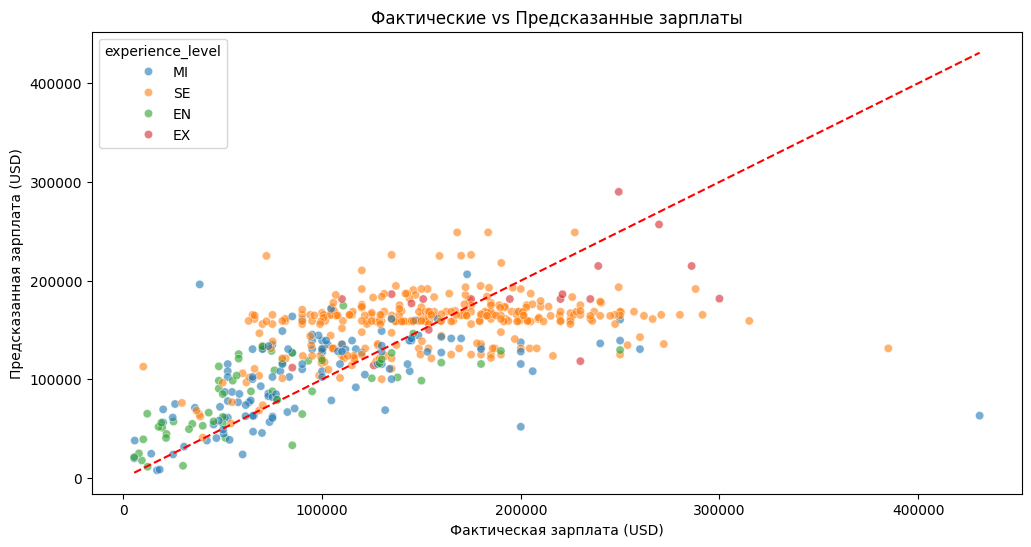

,work_year,remote_ratio,job_title,experience_level,employee_residence,company_location,actual_salary,predicted_salary,abs_error,error_percent
2022,2022,50,3D Computer Vision Researcher,SE,CA,AL,10000,112898.115589,102898.115589,1028.981156
3667,2021,100,Data Scientist,MI,IN,US,5679,37997.205349,32318.205349,569.082679
1257,2023,0,Data Engineer,EN,VN,VN,12000,65170.052094,53170.052094,443.083767
3485,2021,100,Applied Machine Learning Scientist,MI,VN,US,38400,196214.750587,157814.750587,410.975913
3434,2022,100,Computer Vision Engineer,EN,PT,LU,10000,39245.984170,29245.984170,292.459842
2578,2021,50,Power BI Developer,EN,IN,IN,5409,21194.642662,15785.642662,291.840315
3537,2021,50,3D Computer Vision Researcher,MI,IN,IN,5409,19990.517636,14581.517636,269.578806
3696,2021,0,Data Engineer,MI,IT,US,20000,69597.609391,49597.609391,247.988047
2840,2022,100,Data Analyst,EN,BR,BR,7799,25005.773493,17206.773493,220.627946
1695,2023,0,Applied Scientist,SE,US,US,72000,225100.490073,153100.490073,212.639570


In [29]:
# Ваш код здесь
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Создаем DataFrame с фактическими и предсказанными значениями
error_analysis_df = X_test.copy()
error_analysis_df['actual_salary'] = y_test
error_analysis_df['predicted_salary'] = p1.predict(X_test)
error_analysis_df['abs_error'] = np.abs(error_analysis_df['actual_salary'] - error_analysis_df['predicted_salary'])
error_analysis_df['error_percent'] = (error_analysis_df['abs_error'] / error_analysis_df['actual_salary']) * 100

# Топ-20 примеров по абсолютной ошибке
top_errors = error_analysis_df.sort_values('error_percent', ascending=False).head(20)

# Визуализация ошибок
plt.figure(figsize=(12, 6))
sns.scatterplot(x='actual_salary', y='predicted_salary', data=error_analysis_df, alpha=0.6, hue='experience_level')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Фактические vs Предсказанные зарплаты')
plt.xlabel('Фактическая зарплата (USD)')
plt.ylabel('Предсказанная зарплата (USD)')
plt.show()

# Вывод топ-20 ошибок с ключевыми признаками
top_errors[['work_year', 'remote_ratio', 'job_title',
            'experience_level',
            'employee_residence', 'company_location', 
            'actual_salary', 'predicted_salary', 
            'abs_error', 'error_percent']]

In [30]:
# Соотношение локаций компании и сотрудника - 35%
top_errors[top_errors['company_location'] != top_errors['employee_residence']].shape[0]  # 7 из 20

6

In [31]:
# Распределение remote_ratio в ошибках
top_errors['remote_ratio'].value_counts()

remote_ratio
100    8
50     6
0      6
Name: count, dtype: int64

In [32]:
# Распределение по годам
top_errors['work_year'].value_counts()

work_year
2021    8
2023    6
2022    5
2020    1
Name: count, dtype: int64

### Выводы

**Ваш ответ здесь**.

Изучим Топ-20 примеров с наибольшей ошибкой, причем по относительной ошибке, т.к. целевая метрика - MAPE.

1. Албания  
Самая большая ошибка 1172% - уникальное наблюдение #2022, где `company_location` = 'AL' (Albania). Тут `actual_salary` = 10000, а `predicted_salary` = 127256. Интересно то, что для Албании з.п. $10000/год - это примерно среднее значение (источник: https://www.numbeo.com/cost-of-living/country_result.jsp?country=Albania&displayCurrency=EUR). Парадокс в том, что такую ЗП предлагают кандидату в Канаде(!), на что и среагировала модель, предсказавшую зарплату в $127256.
Парадокс не разрешить, поэтому просто удалим это наблюдение из данных.
    > удалить #2022 из данных
2. Географические аномалии  
- 35% из Топ-20 ошибок имеют несовпадение `company_location` и `employee_residence`.  
    > добавить признак "несоответствие локаций"
- 70% из Топ-20 ошибок имеют `remote_ratio` = 100 или 50.
3. Временные аномалии  
- 45% из Топ-20 ошибок имеют `work_year` = 2021, хотя он достаточно старый.
    > Возможная митигация:
    > - учесть инфляцию - привести ЗП к уровню 2023 года, а признак `work_year` удалить.
4. Много ошибок для "бедных" стран.
    > Возможная митигация:
    > - добавление признаков - экономических характеристик страны кандидата (например, уровня з.п., уровня жизни, ВВП на душу населения), предполагая, что предлагаемая ЗП должна быть откалибрована по уровню ЗП в стране найма.
    > - добавление весов обратно пропоциональных частоте появления страны в данных (в CatBoost - sample_weight) 
    > - суперсемплинг для редких стран
5. Ошибки для редких должностей
    > Возможная митигация:
    > - группировка редких должностей в "Other".
    > - суперсемплинг для редких должностей
    > - добавление весов обратно пропоциональных частоте появления должности в данных
 

**Стратегии улучшения модели.**
1. добавить бинарные признаки для наблюдений с комбинациями:
   * удаленка и низкий experience_level 
   * несовпадение локаций + экзотическая локация
2. Добавить иерархические признаки:
   * для `job_title`: блок-функция-уровень
   * для `company_location`: страна, регион, ВВП/на душу, уровень ЗП, уровень расходов
   * для `employee_residence`: -//-
3. Для редких должностей:
   * Semantic embedding названий должностей (например, через Word2Vec)
   * группировка в "Other"
4. Для редких стран:
   * добавление признаков - экономических характеристик страны найма (уровень з.п., уровень жизни(?), ВВП на душу населения), предполагая, что предлагаемая ЗП должна быть откалибрована по уровню ЗП в стране найма.
   * добавление весов обратно пропоциональных частоте появления страны в данных

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [33]:
# признаки связанные с локацией
def add_location_features(df):
    # Признак несоответствия локаций
    df['location_mismatch'] = (df['company_location'] != df['employee_residence']).astype(int)
    
    # Признак удаленной работы для junior
    df['remote_junior'] = ((df['remote_ratio'] >= 50) & 
                          (df['experience_level'] == 'EN')).astype(int)
    
    return df


In [34]:
# признаки связанные с должностью
def process_job_titles(df):
    # Основная роль (role)
    role_mapping = {
        "DEVOPS": ['devops'],
        "MANAGER": ['manager'],
        "ARCHITECT": ['architect', 'strategist'],
        "TECHICIAN": ['technician'],
        'SCIENTIST': ['science', 'scientist'],
        'RESEARCH': ['researcher', 'research'],
        "OPERATIONS": ['data operations', 'mlops'],
        'ANALYST': ['analyst', 'analytics'],
        'ENGINEER': ['engineer', 'developer', 'programmer', 'data management', 'etl', 'infrastructure', 'azure', 'cloud', 'modeler',
                         'data lead', 'data specialist', 'head of data'],
        "QUALITY": ['data quality', 'data quality analyst', 'data quality engineer'],
        'OTHER': []
    }
    
    # Уровень должности (level)
    level_mapping = {
        'JUNIOR': ['junior'],
        'HEAD': ['head', 'director', 'manager', 'principal', 'staff'],
        'LEAD': ['lead'],
        'SPECIALIST': ['specialist', 'consultant', 'architect'],
        'REGULAR': []  # все остальные
    }
    
    # Специализация (domain)
    domain_mapping = {
        'FINANCE': ['financial', 'finance'],
        'MARKETING': ['marketing'],
        'PRODUCT': ['product'],
        'CLOUD': ['azure', 'cloud'],
        'QA': ['quality', 'data quality'],
        'BI': ['bi', 'business intelligence'],
        'ML': ['ml', 'machine learning', 'deep learning', 'ai', 'computer vision', 'nlp', 'mlops'],
        'DATA': ['big data', 'data', 'etl'],
        'GENERAL': []  # все остальные
    }
    
    def get_category(title, mapping):
        title = title.lower()
        for category, keywords in mapping.items():
            if any(keyword in title for keyword in keywords):
                return category
        return list(mapping.keys())[-1]  # возвращаем последнюю категорию как дефолтную
    
    # Создаем новые столбцы
    df['job_role'] = df['job_title'].apply(lambda x: get_category(x, role_mapping))
    df['job_level'] = df['job_title'].apply(lambda x: get_category(x, level_mapping))
    df['job_domain'] = df['job_title'].apply(lambda x: get_category(x, domain_mapping))
    
    # Создаем комбинированные признаки
    df['level_domain_role'] = df['job_level'] + '_' +  df['job_domain']+ '_' + df['job_role']
    
    return df


In [35]:
# Загружаем данные из World Bank
# url = "https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=csv"
# скачается ZIP-архив, в котором лежит CSV-файл
# первые 4 строки - не данные, а описание, поэтому пропускаем
gdp_data = pd.read_csv('./API_NY.GDP.PCAP.CD_DS2_en_csv_v2_62/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_62.csv', skiprows=4)

# Берем последние 4 года (самый последний стобец - пустой)
years = gdp_data.columns[-5:-1]
gdp_by_country = gdp_data.set_index('Country Name')[years]
# Очищаем от NaN значений
gdp_by_country = gdp_by_country.dropna()

# # Создаем словарь для соответствия названий стран и кодов
# country_code_map = {name: code for code, name in zip(iso3166.keys(), iso3166.values())}

# # Добавляем столбец с кодами стран
# gdp_by_country['Country Code'] = gdp_by_country.index.map(country_code_map)


In [36]:
# Экономические признаки
def add_economic_features(df):
    # Создаем словарь для соответствия кодов стран (развернутый iso3166)
    country_code_map = {code: name for code, name in iso3166.items()}
    
    # Добавляем GDP per capita для каждой строки
    def get_gdp(row, gdp_data):
        country_name = country_code_map.get(row['employee_residence'])
        if country_name and country_name in gdp_data.index:
            return gdp_data.loc[country_name, str(row['work_year'])]
        return None
        
    df['GDP_per_capita'] = df.apply(lambda row: get_gdp(row, gdp_by_country), axis=1)
    
    # Заполняем пропущенные значения медианой
    df['GDP_per_capita'] = df['GDP_per_capita'].fillna(df['GDP_per_capita'].median())
    return df


In [37]:
# Применяем все улучшения
df_improved = (df.pipe(add_location_features)
                .pipe(process_job_titles)
                .pipe(add_economic_features)
            )

#### Проверяем улучшение качества

In [38]:
X_train_improved, X_test_improved, y_train, y_test = train_test_split(
    df_improved, y, test_size=0.2, random_state=42
)

cols_cat_improved = df_improved.select_dtypes(include=['object']).columns

# модель с новыми признаками
p_ohe_2 = ColumnTransformer([
    ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cols_cat_improved),
], remainder='passthrough')

p1_improved = Pipeline([
    ('ohe', p_ohe_2),
    ('boost', CatBoostRegressor(verbose=False, random_state=42))
])

p1_improved.fit(X_train_improved, y_train)
predictions = p1_improved.predict(X_test_improved)

_ = evaluate_model(y_test, predictions)

MAPE: 0.41679081806706264
RMSE: 51858.429281368815


/Users/ykonov/Documents/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Вывод

Сравнение метрик качества CatBoost + OHE без дополнительных признаков показывал

| # | MAPE  | RMSE  | Прим.                                       |
|---|-------|-------|---------------------------------------------|
| 1 | 0.42  | 51672 | CatBoost + OHE без дополнительных признаков |
| 2 | 0.42  | 51858 | CatBoost + OHE с дополнительными признаками |

Стало даже незначительно хуже по RMSE.  
**Не будем использовать дополнительные признаки.**

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

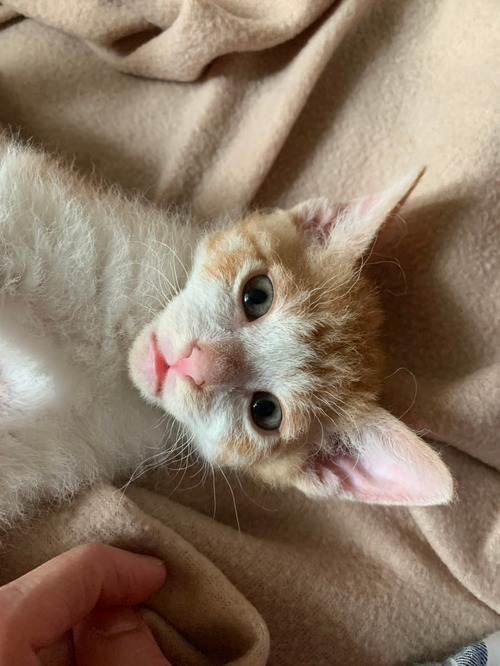